In [2]:
!pip install mojimoji
!pip install janome

     |████████████████████████████████| 133kB 2.7MB/s 
     |████████████████████████████████| 21.5MB 1.4MB/s 


In [12]:
# -*- coding: utf_8 -*-

"""
ExtractData : 秋山さんの本命/義理の基準に基づいてデータを抽出。
LinearClassification : 考えつく基準(材料数・step数)で分類。
DateClassification : 有本さんの日付別の分析。
DishTypeClassification : 有本さんの料理種別の分析。
IngredientClassification : 中井の材料からの予測。
TitleClassification : 中井のタイトルからの予測。
  WordEmbeddingModel : Word2Vecを使用した学習モデル
    ーwakati_0 : 材料からの予測。「手順」「材料」で学習したところかなり高精度。
    ーwakati_1：タイトルからの予測。「タイトル」「手順」「材料」で学習した。
  DNN :PyTorchを使用した学習モデル
    ーwakati_0 : 材料からの予測。70%前後の分類性能。→「本命」「義理」に使われやすい食材は何か。
    ーwakati_1 : タイトルからの予測。65%前後の分類性能。→有川さんの料理種別の分析と一致するか。
ImageClassificationByCNN : 中井のCNNを用いた画像からの予測。
  CNN : PyTorchを使用した学習モデル
ImageClassificationByVGG_1 : 中井のVGG16の多層パーセプトロンをfine tuningした予測。
  VGG_1 : Kerasを使用。VGG16の畳み込み層とプーリング層を固定して多層パーセプトロンを学習。
ImageClassificationByVGG_2 : 中井のVGG16の畳み込み層とプーリング層1ブロックと多層パーセプトロンをfine tuningした予測。
  VGG_2 : Kerasを使用。VGG16の浅い畳み込み層とプーリング層を固定して最深段と多層パーセプトロンを学習。
"""

# 初めにnumpy, pandas, matplotlib, mojimoji, gensim, janome, torch, sklearn, keras, cv2をインストール
# gpuがないとvgg16を用いた学習は行えないので、その場合はgoogle colabを使用

import glob
import os
import cv2
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mojimoji
from gensim.models import word2vec
from janome.tokenizer import Tokenizer
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras import optimizers
from sklearn.model_selection import train_test_split
from IPython.display import Image,display_png
%matplotlib inline

result_vgg_dir = 'result_vgg'
if not os.path.exists(result_vgg_dir):
  os.mkdir(result_vgg_dir)
result_df_dir = 'result_df'
if not os.path.exists(result_df_dir):
  os.mkdir(result_df_dir)
result_label_dir = 'result_label'
if not os.path.exists(result_label_dir):
  os.mkdir(result_label_dir)
result_word_embedding_dir = 'result_word_embedding'
if not os.path.exists(result_word_embedding_dir):
  os.mkdir(result_word_embedding_dir)

csv_data_dir = '/content/drive/My Drive/Colab Notebooks/data'
image_data_dir = '/content/drive/My Drive/Colab Notebooks/data/image_folder'
vgg_batch_size = 6
vgg_nb_epoch = 50

start = time.time()

###########################################################################
#
#   ToolForMoldDataクラス
#
###########################################################################

class ToolForMoldData():
  """
  材料のデータ成形用関数
  """
  @staticmethod
  def mold_all_ingredient(ingredients):
    for index, ingredient in enumerate(ingredients):
      ingredients[index] = ToolForMoldData.mold_ingredient(ingredient)
    return ingredients

  @staticmethod
  def mold_ingredient(ingredient):
    ingredient = str(ingredient)
    # 記号を取り除く
    ingredient = ingredient.replace("○","")
    ingredient = ingredient.replace("●","")
    ingredient = ingredient.replace("◎","")
    ingredient = ingredient.replace("■","")
    ingredient = ingredient.replace("□","")
    ingredient = ingredient.replace("◇","")
    ingredient = ingredient.replace("◆","")
    ingredient = ingredient.replace("▲","")
    ingredient = ingredient.replace("△","")
    ingredient = ingredient.replace("★","")
    ingredient = ingredient.replace("☆","")
    ingredient = ingredient.replace("A","")
    ingredient = ingredient.replace("Ａ","")
    ingredient = ingredient.replace("B","")
    ingredient = ingredient.replace("Ｂ","")
    ingredient = ingredient.replace("C","")
    ingredient = ingredient.replace("Ｃ","")
    ingredient = ingredient.replace("D","")
    ingredient = ingredient.replace("Ｄ","")
    ingredient = ingredient.replace("：","")
    ingredient = ingredient.replace("・","")
    ingredient = ingredient.replace("、","")
    ingredient = ingredient.replace("＞","")
    ingredient = ingredient.replace("※","")
    ingredient = ingredient.replace("＊","")
    ingredient = ingredient.replace("【","")
    ingredient = ingredient.replace("】","")
    # ()や30gや大さじ2などを取り除く
    ingredient = ingredient.split("(")[0]
    ingredient = ingredient.split("（")[0]
    ingredient = ingredient.split("【")[0]
    ingredient = ingredient.split("「")[0]
    ingredient = ingredient.split("［")[0]
    ingredient = ingredient.split("[")[0]
    ingredient = ingredient.split("　")[0]
    ingredient = ingredient.split(" ")[0]
    ingredient = ingredient.split("大さじ")[0]
    ingredient = ingredient.split("小さじ")[0]
    for i in range(10):
      ingredient = ingredient.split("小"+str(i))[0]
      ingredient = ingredient.split("小"+mojimoji.han_to_zen(str(i)))[0]
      ingredient = ingredient.split("大"+str(i))[0]
      ingredient = ingredient.split("大"+mojimoji.han_to_zen(str(i)))[0]
      ingredient = ingredient.split(str(i))[0]
      ingredient = ingredient.split(mojimoji.han_to_zen(str(i)))[0]
    return ingredient

  """
  DNNのデータ成形用関数
  """
  @staticmethod
  def mold_df_with_label_target(df):
    df_with_label_target = df.values
    return df_with_label_target

  @staticmethod
  def mold_df_with_label_ingredient_data(df, model):
    df_with_label_data_2d = np.zeros(100)
    for index, row in df.iterrows():
      df_with_label_data_1d = np.empty(0)
      new_df = pd.DataFrame(index=[], columns=["ingredient", "similarity"])
      for ingredient in row["ingredient"]:
        if ingredient in model.wv.vocab:
          record = pd.Series([ingredient, model.wv.similarity(w1="チョコ", w2=ingredient)], index=new_df.columns)
          new_df = new_df.append(record, ignore_index=True)
      new_df.sort_values("similarity")
      for index, new_row in new_df.iterrows():
        df_with_label_data_1d = np.concatenate([df_with_label_data_1d, model[new_row["ingredient"]]])
      while df_with_label_data_1d.shape[0]<100:
        df_with_label_data_1d = np.concatenate([df_with_label_data_1d, np.ones(20)])
      df_with_label_data_2d = np.vstack([df_with_label_data_2d, df_with_label_data_1d[:100]])
    return df_with_label_data_2d[1:]

  @staticmethod
  def mold_df_with_label_title_data(df, model):
    df_with_label_data_2d = np.ones(80)

    for index, row in df.iterrows():
      # タイトルからチョコと最も関係の深い名詞を1つ
      t = Tokenizer()
      new_title_df = pd.DataFrame(index=[], columns=["title", "similarity"])
      for token in t.tokenize(str(row["title"])):
        if token.part_of_speech.split(",")[0] == "名詞":
          if token.surface in model.wv.vocab:
            record = pd.Series([token.surface, model.wv.similarity(w1="チョコ", w2=token.surface)], index=new_title_df.columns)
            new_title_df = new_title_df.append(record, ignore_index=True)
      new_title_df.sort_values("similarity")
      try:
        df_with_label_data_1d = model[new_title_df.iat[0, 0]]
        try:
          df_with_label_data_1d = np.concatenate([df_with_label_data_1d, model[new_title_df.iat[1,0]]])
          try:
            df_with_label_data_1d = np.concatenate([df_with_label_data_1d, model[new_title_df.iat[2,0]]])
            try:
              df_with_label_data_1d = np.concatenate([df_with_label_data_1d, model[new_title_df.iat[3,0]]])
            except:
              df_with_label_data_1d = np.concatenate([df_with_label_data_1d, np.ones(20)])
          except:
            df_with_label_data_1d = np.concatenate([df_with_label_data_1d, np.ones(40)])
        except:
          df_with_label_data_1d = np.concatenate([df_with_label_data_1d, np.ones(60)])
      except:
        df_with_label_data_1d = np.ones(80)

      df_with_label_data_2d = np.vstack([df_with_label_data_2d, df_with_label_data_1d[:80]])

    return df_with_label_data_2d[1:]
  
  @staticmethod
  def mold_ingredient_to_inference(ingredients=[["砂糖","生クリーム"],["ゴディバ"],["上白糖"],["抹茶"]]):
    df = pd.DataFrame(index=[], columns=["index", "ingredient"])
    for index, ingredient in enumerate(ingredients):
      for ing in ingredient:
        record = pd.Series([index, ing], index=df.columns)
        df = df.append(record, ignore_index=True)
    df = df.groupby("index").agg({"ingredient": list})
    df["label"] = -1
    df["title"] = ""
    return df
  
  @staticmethod
  def mold_recipe_to_inference(recipes=["本格生チョコアイス","ハート型手作りショコラ"]):
    df = pd.DataFrame(index=[], columns=["index", "title"])
    for index, recipe in enumerate(recipes):
      record = pd.Series([index, recipe], index=df.columns)
      df = df.append(record, ignore_index=True)
    df["label"] = -1
    return df

  """
  CNNのデータ成形用関数
  """
  @staticmethod
  def mold_df(df_giri, df_honm):
    # 義理の写真を3次元numpy形式のままレシピIDと結びつける
    df_giri = df_giri[["id1", "title"]]
    giri_images =  glob.glob(image_data_dir + "/1_giri/*")
    new_df_giri = pd.DataFrame(index=[], columns=["id1","img_np"])
    for giri_image in giri_images:
      record = pd.Series([os.path.split(giri_image)[1].split(".jpeg")[0].split(".jpg")[0], cv2.imread(giri_image)], index=new_df_giri.columns)
      new_df_giri = new_df_giri.append(record, ignore_index=True)
    df_giri = pd.merge(df_giri, new_df_giri, how="inner", on="id1")
    df_giri["label"] = 0
    # 本命の写真を3次元numpy形式のままレシピIDと結びつける
    df_honm = df_honm[["id1", "title"]]
    honm_images = glob.glob(image_data_dir + "/2_honmei/*")
    new_df_honm = pd.DataFrame(index=[], columns=["id1","img_np"])
    for honm_image in honm_images:
      record = pd.Series([os.path.split(honm_image)[1].split(".jpeg")[0].split(".jpg")[0], cv2.imread(honm_image)], index=new_df_honm.columns)
      new_df_honm = new_df_honm.append(record, ignore_index=True)
    df_honm = pd.merge(df_honm, new_df_honm, how="inner", on="id1")
    df_honm["label"] = 1
    # データのマージ
    df = pd.concat([df_giri, df_honm])
    df["img_np"] = df["img_np"].map(lambda x: cv2.resize(x, dsize=(227,227)))
    return df

  @staticmethod
  def mold_target(df):
    return df["label"].values.astype(np.int32)

  @staticmethod
  def mold_data(df):
    X_ = np.ones((1,3,227,227))
    for index, row in df.iterrows():
      img_np = row["img_np"].transpose(2,0,1)
      X_ = np.concatenate([X_,img_np.reshape(1,3,227,227)], 0)

    X_ = X_[1:].astype(np.float32) / 255
    return X_
  
  @staticmethod
  def mold_image_to_reference(paths=["/content/drive/My Drive/","/content/drive/My Drive"]):
    images = []
    for path in paths:
      images.append(cv2.imread(path.replace("jpeg","jpg")))
    images_df = pd.DataFrame(index=[], columns=["id","img_np"])
    for i, image in enumerate(images):
      record = pd.Series([i, image], index=images_df.columns)
      images_df = images_df.append(record, ignore_index=True)
    images_df["label"] = -1
    images_df["img_np"] = images_df["img_np"].map(lambda x: cv2.resize(x, dsize=(227,227)))
    return images_df

  """
  VGGのデータ成形用関数
  """

  @staticmethod
  def save_history(history, result_file):
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    nb_epoch = len(acc)
    with open(result_file, "w") as fp:
      fp.write('epoch\tloss\tacc\tval_loss\tval_acc\n')
      for i in range(nb_epoch):
        fp.write("%d\t%f\t%f\t%f\t%f\n" % (i, loss[i], acc[i], val_loss[i], val_acc[i]))

###########################################################################
#
#   ExtractDataクラス
#   ー全csvから必要な要素のみ抜き出し、セッターdfを用意
#     __read_and_concate_csv関数：材料・手順・レシピデータを全年度読み込み、配列に
#     __merge_csv関数：材料・手順・レシピデータを各々全年度マージ
#     __merge_ing_and_rec関数：材料データとレシピデータをマージし、同じレシピの材料をリスト化
#     __extract_choco_data関数：リスト型の材料データでチョコを含むレシピのみを抽出
#     __extract_valentine_data関数：説明・コツ・生い立ちにバレンタインを含むデータのみを抽出
#     __merge_ing_and_stp関数：材料データと手順データをマージし、同じレシピの手順をリスト化
#     __label_data関数：秋山さんの基準に従ってラベル付け、キーワードは初期値として代入も可能
#
###########################################################################

class ExtractData():
  def __init__(
      self,
      GIRI_WORD=["義理", "友チョコ","先輩","大量","上司","配"],
      HONM_WORD=["本命","ほんめい","ホンメイ","彼","恋人","メッセージ","好きな人","手間をかけて","手間はかか","手間がかかる","手間をかかり"],
      IS_PRINT_DF_ALL=True, IS_PRINT_DF_CHOCO=True
      ):
    self.__giri_word = GIRI_WORD
    self.__honm_word = HONM_WORD
    self.__is_print_df_all = IS_PRINT_DF_ALL
    self.__is_print_df_choco = IS_PRINT_DF_CHOCO
    
    self.__main()
  
  def __read_and_concate_csv(self):
    col_names_ing = ["id1", "ingredient", "quantity"]
    col_names_rec = ["id1", "id2", "title", "description", "portions", "point", "background", "date"]
    col_names_stp = ["id1", "serial_number", "step"]
    self.__df_ing = [pd.read_csv(csv_data_dir + "/ingredient/ingredient{}.csv".format(1998+i), sep=',', names=col_names_ing) for i in range(17)]
    self.__df_rec = [pd.read_csv(csv_data_dir + "/recipe/recipe{}.csv".format(1998+i), sep=',', names=col_names_rec) for i in range(17)]
    self.__df_stp = [pd.read_csv(csv_data_dir + "/step/step{}.csv".format(1998+i), sep=',', names=col_names_stp) for i in range(17)]
    #self.__df_ing = [pd.read_csv("./data/ingredient/ingredient{}.csv".format(1998+i), sep=',', names=col_names_ing) for i in range(17)]
    #self.__df_rec = [pd.read_csv("./data/recipe/recipe{}.csv".format(1998+i), sep=',', names=col_names_rec) for i in range(17)]
    #self.__df_stp = [pd.read_csv("./data/step/step{}.csv".format(1998+i), sep=',', names=col_names_stp) for i in range(17)]

  def __merge_csv(self):
    for i in range(16):
      self.__df_ing[0] = pd.concat([self.__df_ing[0],self.__df_ing[i+1]],ignore_index = True)
      self.__df_rec[0] = pd.concat([self.__df_rec[0],self.__df_rec[i+1]],ignore_index = True)
      self.__df_stp[0] = pd.concat([self.__df_stp[0],self.__df_stp[i+1]],ignore_index = True)
    self.__df_ing=self.__df_ing[0].drop("quantity", axis=1)
    self.__df_rec=self.__df_rec[0].drop(["portions", "id2"], axis=1)
    self.__df_stp=self.__df_stp[0].drop("serial_number", axis=1)

  def __merge_ing_and_rec(self):
    self.__df_ing = self.__df_ing.groupby("id1").agg({"ingredient": list})
    self._df = pd.merge(self.__df_rec,self.__df_ing,how="inner",on="id1")
    if self.__is_print_df_all:
      print(self._df.head())

  def __extract_choco_data(self):
    choco_flag = (self._df["ingredient"]=="")
    for index, row in self._df.iterrows():
      for ingredient in row["ingredient"]:
        if "チョコ" in str(ingredient):
          choco_flag[index] = True
    self._df = self._df[choco_flag]
    self._df["ingredient"] = self._df["ingredient"].map(ToolForMoldData.mold_all_ingredient)

  def __extract_valentine_data(self):
    self._df = self._df[
      self._df["title"].str.contains("バレンタイン", na=False) |
      self._df["description"].str.contains("バレンタイン", na=False) |
      self._df["point"].str.contains("バレンタイン", na=False) |
      self._df["background"].str.contains("バレンタイン", na=False)
    ].reset_index(drop=True)
    if self.__is_print_df_choco:
      print(self._df.head())
  
  def __merge_ing_and_stp(self):
    self.__df_stp = self.__df_stp.groupby("id1").agg({"step": list})
    self._df = pd.merge(self.__df_stp,self._df,how="inner",on="id1")

  def __label_data(self):
    self._df["label"] = -1
    for giri_word in self.__giri_word:
      self._df.loc[
        (self._df["title"].str.contains(giri_word, na=False)) |
        (self._df["description"].str.contains(giri_word, na=False)) |
        (self._df["point"].str.contains(giri_word, na=False)) |
        (self._df["background"].str.contains(giri_word, na=False)),
        "label"
      ] = 0
    giri_ids = [
              "99752fcc059cc6baea15ba7eb5baabdef60aae21",
              "c0c54f062173c251e9624e65dcb70e0971bc84fe",
              "58c18c59f3a969147eab0f137652909cdc7971b7",
              "4ae4cc985543a25b91418dfb0f7d8cbdd9ec463e",
              "e64319402dd4040f051f249072e7d1e6b1cd3987",
              "8c0ed1933d13d7575b1988d0fc150a4e539fd509",
              "0dfd983bf75cf25ff9cfd0b236cdac71e16c7e14",
              "3bd1929f5f8f80d3f9ba15549f850403fabaa257",
              "7658f66ad1e75f4331dcf2bb834a47d4312142d4",
              "f8112c4f1d5070546d5cffb2ebfbec0d10b9b136",
              "ea5502fadaf1f31157acf5d3fd6f7add6d698696",
              "32e8ae2bed334484e4186da6977e44031a564a11",
              "1a1f21866e55b99746e15c1d317d45634e979d8e",
              "3309b9bbf39b5e3085962bc6292589f2a709938e",
              "cd978a050ae3dea6d6ef8116508bff9b291e9839",
              "979fe13030947ebeade96488935f23454e3840d2",
              "160e60c380b248aca7e6d7145113409a872c5d71",
              "6eb5a7ae4c2e01b536e680efd126875e167b47db",
              "2e93fcdf5664197a509fa900483b768d273071e9",
              "845222328638d97a6a9540e1abed4c4ae09a7f7f"
    ]
    for giri_id in giri_ids:
      self._df.loc[
        (self._df["id1"].str.contains(giri_id, na=False)),
        "label"
      ] = 0
    for honm_word in self.__honm_word:
      self._df.loc[
        (self._df["title"].str.contains(honm_word, na=False)) |
        (self._df["description"].str.contains(honm_word, na=False)) |
        (self._df["point"].str.contains(honm_word, na=False)) |
        (self._df["background"].str.contains(honm_word, na=False)),
        "label"
      ] = 1
    honm_ids = [
              "55d81830002e588606faf4ce472f3295f1decf0b",
              "69fc7d6e083f8e43bae2101dd2bfe5c272ae575e", 
              "76ed8dc7ee3cf77facfa959d5f9995dde331d99a", 
              "8e36b4ba5bd79ae9047eb99132849ab04db00738", 
              "9bcd5e713ca8b3236be27df9e4c03b38a0d19a07", 
              "5f2d5140911186f6d56c9e58cb9699c45810da18", 
              "5da437390da88ec52c8cbaae0492cd168aac337f", 
              "58c18c59f3a969147eab0f137652909cdc7971b7", 
              "aa0c2f2b759b02b0670916fb0e8c471f790e0e41", 
              "d648df7f2f8f85eabb594d0f7d5faf891cf8df4c", 
              "7069caae76641c4a1ffbf43bb526432dabf926b1", 
              "4a84fd1753f904df29a381d26dda263cf5f0c0c2", 
              "c86315ee0f8ae39e6ae27dd04862dca96e653502", 
              "0745faafb479672c297828d776fadd158893561b", 
              "794ecb826c29a6696485f3e41160da005f14d60b", 
              "3bd1929f5f8f80d3f9ba15549f850403fabaa257", 
              "1134d012c24e496353704d724999250c129ff1f3", 
              "7658f66ad1e75f4331dcf2bb834a47d4312142d4", 
              "84b0a3fb97bf176befe720cd4a2841310ec3878e", 
              "13272d3c3bfe2e0c0488bef236ae06c3d1eed9cb", 
              "c8f25ebada87c97bc6be6aa9a67f06b6df018fb4", 
              "7e7a88d867a59299e725a834e455586a50b7949d", 
              "5463de58758fa49a091c8785b5147f0b32078827", 
              "0940e2f301c63065de112d5af22bb2da10d9badd", 
              "ce922f34cfb8c6e13f15761cee41528007907618", 
              "b36038d9b85f0b481de64bb459e7a960c63209ec", 
              "7dbde2b8400bbdeb00a188417499c2a4fc933888", 
              "4d84c8b5e60eb236a799730f9305192ebf6da76c", 
              "32e8ae2bed334484e4186da6977e44031a564a11", 
              "f4d25cf2051d05db510efac2a3e353e3d6ce7ecc", 
              "bb61e35f31e444e74e2cbc13f61ced0d6ea15a75", 
              "819d906c217377fd5182c3bcbb62b6dde7fab210", 
              "40c60bea3a7e1867cc239827d6f7c1bf500dc778", 
              "cf9f77f7b256b0f6a43d4afbc53082346618b4af", 
              "1bbe3452e89425f86e7bf55b40570b314e4dca60", 
              "b4a15614f75f3bb518c77939ccd646415b9ec4ba", 
              "17382afcd7bb03bcfb8834e732d5ad5aa3636123", 
              "d4ef4aa47d819087ce2e6319cd16c206246abdb7", 
              "454392abc0333f0185596c65528379c74a1898f1", 
              "d4850fe3c0a4c17f5b4d85b8b7e0310379fa7a80", 
              "aff2859f12a0aa4a3667a54ec7004447055e6453", 
              "607ef75b160b217afdfca286510af16002072820", 
              "4ed5b52d6b91b89bbb11ebcdd514000bf0268e67", 
              "afeab0812432be198bdf2f98868f02068b002464", 
              "c4338e5ab9bc68aae2ed8edde0e5fe518c6f668b", 
              "c4004bbac159c4ace55f5daa3f4dfdceb3fe7c40",
              "160e60c380b248aca7e6d7145113409a872c5d71",
              "40f6e4daf780621faab3db5fd5d51aadb828372f",
              "2e93fcdf5664197a509fa900483b768d273071e9",
              "a3d065adaac6f25d035aae97aba1abb664e82ee2"
    ]
    for honm_id in honm_ids:
      self._df.loc[
        (self._df["id1"].str.contains(honm_id, na=False)),
        "label"
      ] = 1

  def __extract_giri_honm_data(self):
    self._df_giri = self._df[self._df["label"]==0].loc[:,["id1","title", "date"]].reset_index(drop=True)
    self._df_honm = self._df[self._df["label"]==1].loc[:,["id1","title", "date"]].reset_index(drop=True)

  def __main(self):
    print("ExtractDataクラス開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__read_and_concate_csv()
    print("csv読み取り完了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__merge_csv()
    print("csv各種マージ完了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__merge_ing_and_rec()
    print("材料とレシピのマージ完了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__extract_choco_data()
    print("チョコを含むレシピの抽出完了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__extract_valentine_data()
    print("バレンタインを含むレシピの抽出完了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__merge_ing_and_stp()
    print("材料と手順のマージ完了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__label_data()
    print("ラベル付完了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__extract_giri_honm_data()
    print("義理データと本命データのみ抽出完了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))

  
  @property
  def df(self):
    return self._df
  @df.setter
  def df(self, df):
    self._df = df

  @property
  def df_giri(self):
    return self._df_giri
  @df_giri.setter
  def df_giri(self, df_giri):
    self._df_giri = df_giri
  
  @property
  def df_honm(self):
    return self._df_honm
  @df_honm.setter
  def df_honm(self, df_honm):
    self._df_honm = df_honm


###########################################################################
#
#   LinearClassificationクラス
#
###########################################################################


class LinearClassification():
  def __init__(self, df_extracted):
    self.__df = df_extracted.df

    self.__main()

  def __classification_by_ing(self):
    df = self.__df[self.__df["label"] != -1]
    df["ing_num"] = df["ingredient"].map(lambda x: len(x))
    x = df["ing_num"].values.astype(np.float32).tolist()
    t = df["label"].values.astype(np.int32).tolist()
    SP = SimplePerceptron()
    self.__j_list_ing = SP.fit(x, t)
    SP.evaluate(x, t)
    

  def __classification_by_stp(self):
    df = self.__df[self.__df["label"] != -1]
    df["stp_num"] = df["step"].map(lambda x: len(x))
    x = df["stp_num"].values.astype(np.float32).tolist()
    t = df["label"].values.astype(np.int32).tolist()
    SP = SimplePerceptron()
    self.__j_list_stp = SP.fit(x, t)
    SP.evaluate(x, t)

  def draw_learning_curve(self, ing_or_stp=0):  # 0でing
    if ing_or_stp == 0:
      plt.plot(self.__j_list_ing)
    else:
      plt.plot(self.__j_list_stp)
    plt.xlabel("epochs")
    plt.ylabel("loss")
  
  def __main(self):
    print("材料数による分類開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__classification_by_ing()
    print("手順数による分類開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__classification_by_stp()


###########################################################################
#
#   DateClassificationクラス
#
###########################################################################


class DateClassification():
  def __init__(self, df_extracted, IS_PRINT_DATE=False):
    self.__df_giri = df_extracted.df_giri
    self.__df_honm = df_extracted.df_honm
    self.__is_print_date = IS_PRINT_DATE

    self.__main()

  def __extract_data_sum(self):
    self.__giri_data = []
    days = [31,28,31,30,31,30,31,31,30,31,30,31]
    for j, day in enumerate(days):
      for k in range(day):
        giri_sum=0
        for i in range(17):
          giri_sum += ("{:04}/{:02}/{:02}".format(1998+i,1+j,1+k)==self.__df_giri["date"]).sum()
        if self.__is_print_date:
          print("{:02}/{:02}".format(1+j,1+k),"{}".format(giri_sum))
        self.__giri_data.append(giri_sum)
    #何月，何日に義理チョコのレシピが何個制作されたか
    self.__honm_data = []
    for j, day in enumerate(days):
      for k in range(31):
        honm_sum=0
        for i in range(17):
          honm_sum += ("{:04}/{:02}/{:02}".format(1998+i,1+j,1+k)==self.__df_honm["date"]).sum()
        if self.__is_print_date:
          print("{:02}/{:02}".format(1+j,1+k),"{}".format(honm_sum))
        self.__honm_data.append(honm_sum)

  def draw_time_series_graph(self):
    print("義理チョコの時系列グラフ")
    ax = plt.axes()
    plt.plot(self.__giri_data)
    ax.set_xticks([0, 31,62,93,124,155,186,217,248,279,310,341])
    ax.set_xticklabels(['1/1', '2/1', '3/1', '4/1', '5/1','6/1','7/1','8/1','9/1','10/1','11/1','12/1'])
    plt.show()
    print("本命チョコの時系列グラフ")
    ax = plt.axes()
    plt.plot(self.__honm_data)
    ax.set_xticks([0, 31,62,93,124,155,186,217,248,279,310,341])
    ax.set_xticklabels(['1/1', '2/1', '3/1', '4/1', '5/1','6/1','7/1','8/1','9/1','10/1','11/1','12/1'])
    plt.show()
  
  def draw_time_series_graph_expanded(self):
    print("義理チョコの時系列グラフ")
    ax = plt.axes()
    plt.plot(self.__giri_data[:82])
    ax.set_xticks([0, 10, 20, 31, 41, 51, 62, 72, 82])
    ax.set_xticklabels(['1/1', '1/11', '1/21', '2/1', '2/11', '2/21', '3/1', '3/11', '3/21'])
    plt.show()
    print("本命チョコの時系列グラフ")
    ax = plt.axes()
    plt.plot(self.__honm_data[:82])
    ax.set_xticks([0, 10, 20, 31, 41, 51, 62, 72, 82])
    ax.set_xticklabels(['1/1', '1/11', '1/21', '2/1', '2/11', '2/21', '3/1', '3/11', '3/21'])
    plt.show()
    print("チョコの差分時系列グラフ(本命-義理)")
    diff_data = (np.array(self.__honm_data[:82])-np.array(self.__giri_data[:82])).tolist()
    ax = plt.axes()
    plt.plot(diff_data[:82])
    ax.set_xticks([0, 10, 20, 31, 41, 51, 62, 72, 82])
    ax.set_xticklabels(['1/1', '1/11', '1/21', '2/1', '2/11', '2/21', '3/1', '3/11', '3/21'])
    plt.show()


  def __main(self):
    print("時系列抽出開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__extract_data_sum()


###########################################################################
#
#   DishTypeClassificationクラス
#
###########################################################################


class DishTypeClassification():
  def __init__(
      self,
      df_extracted,
      DISH_TYPE=[["カップケーキ　", "マフィン　　　"], ["生チョコ　　　"], ["トリュフ　　　"], ["パイ　　　　　"], ["ブラウニー　　"]]
    ):
    self.__df= df_extracted.df
    self.__dish_types = DISH_TYPE

    self.__main()

  def __label_dish_type(self):
    self.__df_giri = self.__df[self.__df["label"] == 0]
    self.__df_honm = self.__df[self.__df["label"] == 1]
    self.__df_giri["DishType"] = -1
    self.__df_honm["DishType"] = -1
    print("未分類　　　　　　　"+str((self.__df["label"]==-1).sum()).ljust(6))
    print("義理　　　　　　　　"+str((self.__df["label"]==0).sum()).ljust(6)+"\t割合［％］\t"+str(100*(self.__df["label"]==0).sum()/((self.__df["label"]==0).sum()+(self.__df["label"]==1).sum())).ljust(6))
    print("本命　　　　　　　　"+str((self.__df["label"]==1).sum()).ljust(6)+"\t割合［％］\t"+str(100*(self.__df["label"]==1).sum()/((self.__df["label"]==0).sum()+(self.__df["label"]==1).sum())).ljust(6))
    self.__choco_giri = []
    self.__choco_honm = []
    self.__choco_giri.append(100*(self.__df["label"]==0).sum()/((self.__df["label"]==0).sum()+(self.__df["label"]==1).sum()))
    self.__choco_honm.append(100*(self.__df["label"]==1).sum()/((self.__df["label"]==0).sum()+(self.__df["label"]==1).sum()))
    self.__dish_types_0 = []
    for index, dish_types in enumerate(self.__dish_types):
      self.__dish_types_0.append(dish_types[0])
      for dish_type in dish_types:
        self.__df_giri.loc[
                           (self.__df_giri["title"].str.contains(dish_type.replace("　",""), na=False)) |
                           (self.__df_giri["description"].str.contains(dish_type.replace("　",""), na=False)) |
                           (self.__df_giri["point"].str.contains(dish_type.replace("　",""), na=False)) |
                           (self.__df_giri["background"].str.contains(dish_type.replace("　",""), na=False)),
                           "DishType"
        ] = index
        self.__df_honm.loc[
                           (self.__df_honm["title"].str.contains(dish_type.replace("　",""), na=False)) |
                           (self.__df_honm["description"].str.contains(dish_type.replace("　",""), na=False)) |
                           (self.__df_honm["point"].str.contains(dish_type.replace("　",""), na=False)) |
                           (self.__df_honm["background"].str.contains(dish_type.replace("　",""), na=False)),
                           "DishType"
        ] = index
        for i_row, row in self.__df_giri.iterrows():
          for ingredient in row["ingredient"]:
            if ingredient in dish_type.replace("　",""):
              row["DishType"] = index
        for i_row, row in self.__df_honm.iterrows():
          for ingredient in row["ingredient"]:
            if ingredient in dish_type.replace("　",""):
              row["DishType"] = index
      self.__choco_giri.append(100*(self.__df_giri["DishType"]==index).sum()/((self.__df_giri["DishType"]==index).sum()+(self.__df_honm["DishType"]==index).sum()))
      self.__choco_honm.append(100*(self.__df_honm["DishType"]==index).sum()/((self.__df_giri["DishType"]==index).sum()+(self.__df_honm["DishType"]==index).sum()))
      print("義理　"+dish_types[0]+str((self.__df_giri["DishType"]==index).sum()).ljust(6)+"\t割合［％］\t"+str(self.__choco_giri[index+1]).ljust(6))
      print("本命　"+dish_types[0]+str((self.__df_honm["DishType"]==index).sum()).ljust(6)+"\t割合［％］\t"+str(self.__choco_honm[index+1]).ljust(6))
  
  def __save_giri_honm_csv(self):
    self.__df_giri.to_csv(os.path.join(result_label_dir,'df_giri.csv'))
    self.__df_honm.to_csv(os.path.join(result_label_dir,'df_honm.csv'))
  
  def draw_bar_chart(self, DISH_TYPE=[]):
    if len(DISH_TYPE) > 0:
      self.__dish_types = DISH_TYPE
      self.__label_dish_type()
    self.__dish_types_0.insert(0,"全体")
    left = self.__dish_types_0
    for index, dish_type_0 in enumerate(self.__dish_types_0):
      self.__dish_types_0[index]= dish_type_0.replace("　","")
    plt.bar(left, self.__choco_giri, color="green")
    plt.bar(left, self.__choco_honm, bottom=self.__choco_giri, color="orange")
    print("文字は潰れていますが、左から、",self.__dish_types_0, "です。")
  
  def __main(self):
    print("DishTypeラベル付開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__label_dish_type()
    print("df_giriとdf_honmを保存します\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__save_giri_honm_csv()


###########################################################################
#
#   IngredientClassificationクラス
#
###########################################################################


class IngredientClassification():
  def __init__(self, df_extracted):
    self.__df = df_extracted.df
    self.__model_instance = WordEmbeddingModel(
        self.__df,
        TOKENIZE_TYPE=0,
        IS_PRINT_WAKATI=True,
        IS_SKIP_GRAM=False,
        VECTOR_DIMENSION=20,
        MIN_COUNT_FILTER=1,
        WORDS_FOR_LEARN=10,  # 周辺単語の抽出数
        IS_USE_SOFTMAX = True
    )
    self.__model = self.__model_instance.model

    self.__main()
  
  def search_neighborhood_word(self, SEARCH_WORD=["チョコ","小麦粉", "砂糖","グラニュー糖","蜂蜜", "はちみつ", "ハチミツ"]):
    self.__model_instance.search_neighborhood_word(SEARCH_WORD)
  
  def calculate_similarity(self, SIMILAR_WORD=[["砂糖","上白糖"],["砂糖","はちみつ"],["砂糖","包丁"]]):
    self.__model_instance.calculate_similarity(SIMILAR_WORD)
  
  def __training(self):
    net = NetDNN(n_in=100)
    self.__dnn_instance = DNN(net)

    df = self.__df[self.__df["label"] != -1]

    """材料を代表5つ(最もチョコと関連が深いもの)に絞る"""
    df_with_label_target = ToolForMoldData.mold_df_with_label_target(df["label"])
    df_with_label_data = ToolForMoldData.mold_df_with_label_ingredient_data(df, self.__model)
    
    """テストデータの形成"""
    X_train, X_test, Y_train, Y_test = train_test_split(df_with_label_data, df_with_label_target, test_size = 0.25)

    """テンソルへの変換"""
    X_train, X_test, Y_train, Y_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(Y_train).long(), torch.from_numpy(Y_test).long()
    print("IngredientClassificationクラスのTrainDataの次元：{}".format(X_train.shape))
    print("IngredientClassificationクラスのTrainTargetの次元：{}".format(Y_train.shape))
    print("IngredientClassificationクラスのTestDataの次元：{}".format(X_test.shape))
    print("IngredientClassificationクラスのTestTargetの次元：{}".format(Y_test.shape))

    """DNNモデルへの代入"""
    self.__epoch_error_graph = self.__dnn_instance.fit(X_train, Y_train, X_test, Y_test)

    self.__dnn_instance.evaluate(X_test, Y_test)

  def draw_learning_curve(self):
    plt.plot(self.__epoch_error_graph)
    plt.xlabel("epochs")
    plt.ylabel("loss")
  
  def __main(self):
    print("DNN学習開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__training()
    print("DNN学習終了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
  
  def inference_by_df(self, df):
    df = df[df["label"] == -1]
    X_validation = torch.from_numpy(ToolForMoldData.mold_df_with_label_ingredient_data(df, self.__model)).float()
    self.__dnn_instance.inference(X_validation, df)
  
  def inference_by_ingredient(self, ingredients):
    df = ToolForMoldData.mold_ingredient_to_inference(ingredients=[["砂糖","生クリーム"],["ゴディバ"],["上白糖"],["抹茶"]])
    X_validation = torch.from_numpy(ToolForMoldData.mold_df_with_label_ingredient_data(df, self.__model)).float()
    self.__dnn_instance.inference(X_validation, df)

###########################################################################
#
#   TitleClassificationクラス
#
###########################################################################


class TitleClassification():
  def __init__(self, df_extracted):
    self.__df = df_extracted.df
    self.__model_instance = WordEmbeddingModel(
        self.__df,
        TOKENIZE_TYPE=1,
        IS_PRINT_WAKATI=True,
        IS_SKIP_GRAM=False,
        VECTOR_DIMENSION=20,
        MIN_COUNT_FILTER=1,
        WORDS_FOR_LEARN=10,  # 周辺単語の抽出数
        IS_USE_SOFTMAX = True
    )
    self.__model = self.__model_instance.model

    self.__main()
  
  def search_neighborhood_word(self, SEARCH_WORD=["チョコ","小麦粉", "砂糖","グラニュー糖","蜂蜜", "はちみつ", "ハチミツ"]):
    self.__model_instance.search_neighborhood_word(SEARCH_WORD)
  
  def calculate_similarity(self, SIMILAR_WORD=[["砂糖","上白糖"],["砂糖","はちみつ"],["砂糖","包丁"]]):
    self.__model_instance.calculate_similarity(SIMILAR_WORD)
  
  def __training(self):
    net = NetDNN(n_in=80)
    self.__dnn_instance = DNN(net)
    df = self.__df[self.__df["label"] != -1]

    """材料を代表5つ(最もチョコと関連が深いもの)に絞る"""
    df_with_label_target = ToolForMoldData.mold_df_with_label_target(df["label"])
    df_with_label_data = ToolForMoldData.mold_df_with_label_title_data(df, self.__model)
    
    """テストデータの形成"""
    X_train, X_test, Y_train, Y_test = train_test_split(df_with_label_data, df_with_label_target, test_size = 0.25)

    """テンソルへの変換"""
    X_train, X_test, Y_train, Y_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(Y_train).long(), torch.from_numpy(Y_test).long()
    print("TitleClassificationクラスのTrainDataの次元：{}".format(X_train.shape))
    print("TitleClassificationクラスのTrainTargetの次元：{}".format(Y_train.shape))
    print("TitleClassificationクラスのTestDataの次元：{}".format(X_test.shape))
    print("TitleClassificationクラスのTestTargetの次元：{}".format(Y_test.shape))

    """DNNモデルへの代入"""
    self.__epoch_error_graph = self.__dnn_instance.fit(X_train, Y_train, X_test, Y_test)

    self.__dnn_instance.evaluate(X_test, Y_test)

  def draw_learning_curve(self):
    plt.plot(self.__epoch_error_graph)
    plt.xlabel("epochs")
    plt.ylabel("loss")

  def __main(self):
    print("DNN学習開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__training()
    print("DNN学習終了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
  
  def inference_by_df(self, df):
    df = df[df["label"] == -1]
    X_validation = torch.from_numpy(ToolForMoldData.mold_df_with_label_title_data(df, self.__model)).float()
    self.__dnn_instance.inference(X_validation, df)
  
  def inference_by_title(self, recipes):
    df = ToolForMoldData.mold_recipe_to_inference(recipes=["本格生チョコアイス","ハート型手作りショコラ"])
    X_validation = torch.from_numpy(ToolForMoldData.mold_df_with_label_title_data(df, self.__model)).float()
    self.__dnn_instance.inference(X_validation, df)


###########################################################################
#
#   ImageClassificationByCNNクラス
#
###########################################################################

class ImageClassificationByCNN():
  def __init__(self, df_extracted):
    net = NetCNN()
    self.__cnn_instance = CNN(net)
    self.__df_giri = df_extracted.df_giri
    self.__df_honm = df_extracted.df_honm

    self.__main()
  
  def __read_csv(self):
    self.__df = ToolForMoldData.mold_df(self.__df_giri, self.__df_honm)

  def __training(self):
    X_ = ToolForMoldData.mold_data(self.__df)
    Y_ = ToolForMoldData.mold_target(self.__df)
    X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_, test_size=0.2)
    X_train, X_test, Y_train, Y_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(Y_train).long(), torch.from_numpy(Y_test).long()
    print("ImageClassificationクラスのTrainDataの次元：{}".format(X_train.shape))
    print("ImageClassificationクラスのTrainTargetの次元：{}".format(Y_train.shape))
    print("ImageClassificationクラスのTestDataの次元：{}".format(X_test.shape))
    print("ImageClassificationクラスのTestTargetの次元：{}".format(Y_test.shape))
    self.__epoch_error_graph = self.__cnn_instance.fit(X_train, Y_train, X_test, Y_test)

  def draw_learning_curve(self):
    plt.plot(self.__epoch_error_graph)
    plt.xlabel("epochs")
    plt.ylabel("loss")

  def __main(self):
    print("CNN学習開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__read_csv()
    self.__training()
    print("CNN学習終了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))

  def inference(self, paths):
    df = ToolForMoldData.mold_image_to_reference(paths)
    X_validation = torch.from_numpy(ToolForMoldData.mold_data(df)).float()
    df_predicted = self.__cnn_instance.inference(X_validation, df)
    for index, row in df_predicted.iterrows():
      img = cv2.imread(paths[index])
      plt.imshow(img[:, :, ::-1])
      if row["label"] == 0:
        print("義理")
      elif row["label"] == 1:
        print("本命")
      else:
        print("error")


###########################################################################
#
#   ImageClassificationByVGG_1クラス
#
###########################################################################

class ImageClassificationByVGG_1():
  def __init__(self):
    self.__vgg_model = VGG_1()
    self.__main()
  
  def __training(
      self,
      nb_epoch=vgg_nb_epoch,
      batch_size=vgg_batch_size,
      img_height=227,
      img_width=227
  ):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255, validation_split=0.2)
    # 学習データ
    train_generator = datagen.flow_from_directory(
        image_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode=None,
        subset='training')
    print('train_generator:',train_generator.samples)
    # テストデータ
    validation_generator = datagen.flow_from_directory(
        image_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode=None,
        subset='validation')
    print('validation_generator:',validation_generator.samples)

    self.__vgg_model.extract_features(train_generator, validation_generator)
    history = self.__vgg_model.fit_fc(nb_epoch=nb_epoch, batch_size=batch_size)
    self.__acc = history.history['accuracy']
    self.__val_acc = history.history['val_accuracy']
    self.__loss = history.history['loss']
    self.__val_loss = history.history['val_loss']
  
  def draw_learning_curve(self, draw_loss=True, draw_acc=True):

    epochs = range(len(self.__acc))
    if draw_acc:
      # 1) Accracy Plt
      plt.plot(epochs, self.__acc, 'bo' ,label = 'training acc')
      plt.plot(epochs, self.__val_acc, 'b' , label= 'validation acc')
      plt.title('Training and Validation acc')
      plt.legend()
      plt.figure()
    if draw_loss:
      # 2) Loss Plt
      plt.plot(epochs, self.__loss, 'bo' ,label = 'training loss')
      plt.plot(epochs, self.__val_loss, 'b' , label= 'validation loss')
      plt.title('Training and Validation loss')
      plt.legend()
      plt.show()

  def __main(self):
    print("VGG_1学習開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__training()
    print("VGG_1学習終了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))


###########################################################################
#
#   ImageClassificationByVGG_2クラス
#
###########################################################################


class ImageClassificationByVGG_2():
  def __init__(self):
    self.__vgg_model = VGG_2()
    self.__main()

  def __training(
      self,
      nb_epoch=vgg_nb_epoch,
      batch_size=vgg_batch_size,
      verbose=1,
      img_height=227,
      img_width=227
  ):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)
    # 学習データ
    train_generator = datagen.flow_from_directory(
        image_data_dir,
        target_size=(img_height, img_width),
        class_mode='binary',
        subset='training')
    print('train_generator:',train_generator.samples)
    # テストデータ
    validation_generator = datagen.flow_from_directory(
        image_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        subset='validation')
    print('validation_generator:',validation_generator.samples)
    
    history = self.__vgg_model.fit_fc(
        train_generator=train_generator,
        validation_generator=validation_generator,
        nb_epoch=nb_epoch, 
        batch_size=batch_size,
        verbose=verbose,
        img_height=img_height,
        img_width=img_width)
    
    self.__acc = history.history['accuracy']
    self.__val_acc = history.history['val_accuracy']
    self.__loss = history.history['loss']
    self.__val_loss = history.history['val_loss']
  
  def draw_learning_curve(self, draw_loss=True, draw_acc=True):
    epochs = range(len(self.__acc))
    if draw_acc:
      # 1) Accracy Plt
      plt.plot(epochs, self.__acc, 'bo' ,label = 'training acc')
      plt.plot(epochs, self.__val_acc, 'b' , label= 'validation acc')
      plt.title('Training and Validation acc')
      plt.legend()
      plt.figure()
    if draw_loss:
      # 2) Loss Plt
      plt.plot(epochs, self.__loss, 'bo' ,label = 'training loss')
      plt.plot(epochs, self.__val_loss, 'b' , label= 'validation loss')
      plt.title('Training and Validation loss')
      plt.legend()
      plt.show()

  def inference(self, img_path):
    self.__vgg_model.inference(img_path)

  def __main(self):
    print("VGG_2学習開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__training()
    print("VGG_2学習終了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    
  
###########################################################################
#
#   WordEmbeddingModelクラス
#   ー単語埋め込み表現の最終的なモデルのセッターmodelを用意
#   ー定数TOKENIZE_TYPEにより関数__tokenize_recipeを指定
#     __tokenize_recipe_0関数：材料と手順中から抽出した名詞を学習の訓練データ用に蓄積
#     __tokenize_recipe_1関数：タイトルと材料・手順中から抽出した名詞を学習の訓練データ用に蓄積
#     __save_wakati_as_txt関数：抽出した全単語を並べたテキストファイルを保存
#     __fit_model関数：先ほどのwakati.txtを用いてword2vecのCBOWによる単語埋め込み表現の学習
#     search_neighborhood_word関数：近傍の10単語を羅列することで単語表現の確認
#     calculate_simularity関数：単語どうしのベクトル的近さを数値表現することで類似単語の類推
#
###########################################################################


class WordEmbeddingModel():
  def __init__(
      self, df,
      TOKENIZE_TYPE=0,  # 0ならwakati_0、1ならwakati_1
      IS_PRINT_WAKATI=True,
      IS_SKIP_GRAM = False,  # FalseならCBOW, Trueならskip_gram
      VECTOR_DIMENSION=20,
      MIN_COUNT_FILTER=1,
      WORDS_FOR_LEARN=10,  # 周辺単語の抽出数
      IS_USE_SOFTMAX = True
    ):
    self.__df = df
    self.__tokenize_type = TOKENIZE_TYPE
    self.__is_print_wakati = IS_PRINT_WAKATI
    self.__is_skip_gram = IS_SKIP_GRAM
    self.__vector_dimension = VECTOR_DIMENSION
    self.__min_count_filter = MIN_COUNT_FILTER
    self.__words_for_learn = WORDS_FOR_LEARN
    self.__is_use_softmax = IS_USE_SOFTMAX

    self.__main()
  
  def __tokenize_recipe_0(self):
    self.__wakati = ""
    t = Tokenizer()
    for index, row in self.__df.iterrows():
      for ingredient in row["ingredient"]:
        self.__wakati = self.__wakati + str(ingredient) + " "
      for step in row["step"]:
        for token in t.tokenize(str(step)):
          if token.part_of_speech.split(",")[0] == "動詞" or token.part_of_speech.split(",")[0] == "名詞" or token.part_of_speech.split(",")[0] == "形容詞": 
            self.__wakati = self.__wakati + "*" + ToolForMoldData.mold_ingredient(token.surface) + " "
  
  def __tokenize_recipe_1(self):
    self.__wakati = ""
    t = Tokenizer()
    for index, row in self.__df.iterrows():
      for token in t.tokenize(str(row["title"])):
        if token.part_of_speech.split(",")[0] == "名詞":
          self.__wakati = self.__wakati + ToolForMoldData.mold_ingredient(token.surface) + " "
      for ingredient in row["ingredient"]:
        self.__wakati = self.__wakati + str(ingredient) + " "
      for step in row["step"]:
        for token in t.tokenize(str(step)):
          if token.part_of_speech.split(",")[0] == "動詞" or token.part_of_speech.split(",")[0] == "名詞" or token.part_of_speech.split(",")[0] == "形容詞": 
            self.__wakati = self.__wakati + "*" + ToolForMoldData.mold_ingredient(token.surface) + " "
  
  def __save_wakati_as_txt(self):
    if self.__is_print_wakati:
      print(self.__wakati[:300])
    with open(os.path.join(result_word_embedding_dir,'wakati_{}.txt'.format(self.__tokenize_type)),mode='w',encoding = 'utf-8') as f:
      f.write(self.__wakati)
  
  def __fit_model(self):
    sentences = word2vec.LineSentence(os.path.join(result_word_embedding_dir,'wakati_{}.txt'.format(self.__tokenize_type))) 
    self._model = word2vec.Word2Vec(
        sentences,
        sg = 1 if self.__is_skip_gram else 0,
        size = self.__vector_dimension,
        min_count = self.__min_count_filter,
        window = self.__words_for_learn,
        hs = 1 if self.__is_use_softmax else 0
    )
    self._model.save(os.path.join(result_word_embedding_dir,"save.model"))
  
  def search_neighborhood_word(self,SEARCH_WORD=["チョコ","小麦粉", "砂糖","グラニュー糖","蜂蜜", "はちみつ", "ハチミツ"]):
    for search_word in SEARCH_WORD:
      print(str(search_word)+"の近傍")
      try:
        for i in range(20):
          j = 0
          results = self._model.wv.most_similar(positive=[str(search_word)], topn=10+i)
          for result in results:
            if "*" not in result:
              j += 1
          if j >= 10:
            for result in results:
              print(result)
            print("")
            break
      except:
        print("材料にありません")
    
  def calculate_similarity(self,SIMILAR_WORD=[["砂糖","上白糖"],["砂糖","はちみつ"],["砂糖","包丁"]]):
    for similar_word in SIMILAR_WORD:
      try:
        print(str(similar_word[0])+"と"+str(similar_word[1])+"の類似度：\t"+str(self._model.wv.similarity(w1=similar_word[0], w2=similar_word[1])))
      except:
        print("入力の型が異なる、または該当する単語がない可能性があります")
  
  def __main(self):
    print("分かち書き開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    if self.__tokenize_type == 0:
      self.__tokenize_recipe_0()
    elif self.__tokenize_type == 1:
      self.__tokenize_recipe_1()
    print("分かち書き完了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__save_wakati_as_txt()
    print("単語埋め込みモデル作成中\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
    self.__fit_model()
  
  @property
  def model(self):
    return self._model

  @model.setter
  def model(self, model):
    self._model = model


###########################################################################
#
#   SimplePerceptronクラス
#   ーnumpyを用いた単純パーセプトロンを構築するクラス
#     __forward関数：誤差の順伝播を行う関数
#     __activation_function関数：活性化関数を計算
#     __activation_function_d関数：活性化関数の微分を計算
#     __J関数：推定する出力と期待する出力の誤差を計算
#     __delta関数：重みとバイアス項の更新量を計算
#     __fit関数：学習開始
#
###########################################################################

class SimplePerceptron():
  def __init__(
      self,
      nb_epochs=1000,   # 1訓練データセットの使用学習回数
      alpha=0.0005,  # 学習率
  ):

    self.__nb_epochs = nb_epochs
    self.__alpha = alpha

  def __y(self, x):
    return 1 * ((self.__w * x + self.__b) > 0)

  def fit(self, x, t):
    # 重みとバイアス項の初期化
    self.__w = np.random.rand()
    self.__b = 0
    # コスト関数の値がどう変わったのかを保存するリストを初期化
    j_list = []
    # 重み更新ループ
    for epoch in range(self.__nb_epochs):
      j = 0
      for i in range(len(x)):
        delta_w = (t[i] - self.__y(x[i])) * x[i]
        delta_b = (t[i] - self.__y(x[i]))
        self.__w += delta_w * self.__alpha
        self.__b += delta_b * self.__alpha
        j += (t[i] - self.__y(x[i]))**2
      j_list.append(j / 2)
      if (epoch+1)%100 == 0:
        print("Epoch : {:04}/{:04}\t Loss : {:.4f}".format(epoch+1, self.__nb_epochs, j/2))
    return j_list
  
  def evaluate(self, x, t):
    accuracy = 0
    for i in range(len(x)):
      y = self.__y(x[i])
      if y == t[i]:
        accuracy += 1
    print("Accuracy...{:.3f}%".format(100*accuracy / len(x)))
    print("w:{:.6f}".format(self.__w))
    print("b:{:.6f}".format(self.__b))
    print("境界値-b/w:{:.6f}".format(- self.__b / self.__w))

###########################################################################
#
#   NetDNNクラス
#   ーPyTorchを用いたDNNのニューラルネットワークを構築するクラス
#     コンストラクタ
#     ー入力層：n_in次元の入力をn_hidden[0]次元の出力にする
#     ー隠れ層：n_hiddensの要素数だけ隠れ層が存在する
#     ー出力層：n_outで2次元の出力。argmaxが予想となる
#     forward関数：誤差の順伝播を行う関数、活性化関数としてReLU関数を使用
#
###########################################################################


class NetDNN(nn.Module):
  def __init__(self, n_in=100, n_hiddens=[256,256,256,256], n_out=2):
    super(NetDNN, self).__init__()

    self.__fc_in = nn.Linear(n_in, n_hiddens[0])
    self.__fc = [nn.Linear(n_hiddens[i], n_hiddens[i+1]) for i in range(len(n_hiddens)-1)]
    self.__fc_out = nn.Linear(n_hiddens[-1], n_out)
  
  def forward(self, x):
    x = F.relu(self.__fc_in(x))
    for fc in self.__fc:
      x = F.relu(fc(x))
    x = self.__fc_out(x)
    return F.log_softmax(x, dim=0)


###########################################################################
#
#   DNNクラス
#   ーPyTorchを用いたDNNのニューラルネットワークを学習するクラス
#     __loss関数：誤差関数の定義、交差エントロピー誤差関数を用いた
#     __training関数：最適化のための諸設定、学習率に応じて勾配降下法に従う
#     fit関数：学習とテストを同時に行う、各パラメータは指定可能
#     evaluate関数：結果の評価を行う
#     inference関数：推論を行う、成形したデータフレームを代入することで様々な実験も
#
###########################################################################


class DNN():

  result_label_index = 0

  def __init__(self, net):
    self.__net = net

  def __loss(self):
    cross_entropy = nn.CrossEntropyLoss()
    return cross_entropy
  
  def __training(self):
    optimizer = optim.SGD(
        self.__net.parameters(),
        lr=0.01
    )
    return optimizer

  def fit(
      self, X_train, Y_train, X_test, Y_test,
      nb_epoch = 5000, batch_size = 15,
      verbose=1
    ):
    self.__net.train()
    criterion = self.__loss()
    optimizer = self.__training()
    train = TensorDataset(X_train, Y_train)
    test = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
    loss_list = []

    for epoch in range(nb_epoch):
      self.__net.train()
      loss_ = 0
      for X_, Y_ in train_loader:
        X_, Y_ = Variable(X_), Variable(Y_)
        optimizer.zero_grad()
        y = self.__net(X_)
        loss = criterion(y, Y_)
        loss.backward()
        optimizer.step()
        loss_ += loss.item()
      loss_list.append(loss_)

      self.__net.eval()
      correct_ = 0
      with torch.no_grad():
        for X_, Y_ in test_loader:
          X_, Y_ = Variable(X_), Variable(Y_)
          y = self.__net(X_)
          _, predicted = torch.max(y.data, 1)
          correct_ += predicted.eq(Y_.data.view_as(predicted)).sum()
      data_num=len(test_loader.dataset)
      
      if verbose == 1:
        if (epoch+1)%(nb_epoch/50) == 0:
          print("Epoch : {:04}/{:04}\t Loss : {:.4f}\t Accuracy : {:03}/{:03} ({:.0f}%)".format(epoch+1, nb_epoch, loss_, correct_, data_num,100.*correct_ /data_num))
    return loss_list

  def evaluate(self, X_test, Y_test):
    self.__net.eval()
    X_, Y_ = Variable(X_test), Variable(Y_test)
    y = self.__net(X_)
    predicted = torch.max(y.data, 1)[1]
    accuracy_ = sum(Y_test.data.numpy() == predicted.numpy()) / len(Y_test.data.numpy())
    print("Accuracy...{:.3f}%".format(100*accuracy_))

  def inference(self, X_validation, df):
    self.__net.eval()
    X_ = Variable(X_validation)
    result = torch.max(self.__net(X_).data, 1)[1]
    df["label"] = pd.Series(result.numpy())
    print(df.head())
    df.to_csv(os.path.join(result_label_dir,"result_label_{}.csv".format(DNN.result_label_index)))
    print("DNNより作成した結果csvをresult_label_{}.csvに保存しました".format(DNN.result_label_index))
    DNN.result_label_index += 1


###########################################################################
#
#   NetCNNクラス
#   ーPyTorchを用いたCNNのニューラルネットワークを構築するクラス
#     コンストラクタ：
#     ーblock1
#       畳み込み：    チャンネル  3→ 96   画像サイズ227→ 55
#       プーリング： チャンネル 96→96   画像サイズ  55→ 27
#     ーblock2
#       畳み込み：    チャンネル 96→256 画像サイズ  27→ 13
#       プーリング： チャンネル256→256画像サイズ  13→ 13
#     ーblock3
#       畳み込み：    チャンネル256→384 画像サイズ  27→ 13
#       畳み込み：    チャンネル384→384 画像サイズ  13→ 13
#       畳み込み：    チャンネル384→256 画像サイズ  13→ 13
#       プーリング： チャンネル256→256 画像サイズ  13→   5
#     ーfull_connection：inputが96000、outputが2のニューラルネットワーク、ドロップアウトを使用
#     forward関数：誤差の順伝播を行う関数、活性化関数としてReLU関数を使用
#
###########################################################################


class NetCNN(nn.Module):
    def __init__(self):

        super(NetCNN, self).__init__() # nn.Moduleを継承する

        # img = cv2.resize(img, dsize=(227,227))
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),  # 入力サイズ227→出力サイズ55
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 入力サイズ55→出力サイズ27
            nn.BatchNorm2d(96)  # 出力チャンネル96
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=1),  # 入力サイズ27→出力サイズ27
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 入力サイズ27→出力サイズ13
            nn.BatchNorm2d(256)  # 出力チャンネル256
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),  # 入力サイズ13→出力サイズ13
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),  # 入力サイズ13→出力サイズ13
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),  # 入力サイズ13→出力サイズ13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 入力サイズ13→出力サイズ6
            nn.BatchNorm2d(256)  # 出力チャンネル256
        )
        self.full_connection = nn.Sequential(
            nn.Linear(in_features=256*5*5, out_features=4096),  # in_featuresは直前の出力ユニット数
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=64, out_features=2),
        )


    def forward(self, x):

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), 256*5*5)  # 6じゃなくて5??

        y = self.full_connection(x)
        
        return y


###########################################################################
#
#   CNNクラス
#   ー畳み込み層とプーリング層で特徴抽出を行った後DNNに代入
#     __loss関数：交差エントロピー誤差関数を使用
#     __training関数：最適化にはAdamを使用
#     fit関数：学習モードで各エポック重みを更新、推論モードで精度算出
#     inference関数：画像を受け取ると義理か本命かの判断を行う
#
###########################################################################


class CNN():

  result_label_index = 0

  def __init__(self, net):
    self.__net = net

  def __loss(self):
    return nn.CrossEntropyLoss()

  def __training(self):
    return optim.Adam(self.__net.parameters(), lr=0.01)

  def fit(
      self, X_train, Y_train, X_test, Y_test,
      nb_epoch = vgg_nb_epoch, batch_size = vgg_batch_size,
      verbose=1
  ):

    criterion = self.__loss()
    optimizer = self.__training()
    train_ = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_, batch_size=batch_size, shuffle=True)
    test_ = TensorDataset(X_test, Y_test)
    test_loader = DataLoader(test_, batch_size=batch_size, shuffle=False)

    loss_list = []

    for epoch in range(nb_epoch):

      self.__net.train()
      loss_ = 0
      for X_, Y_ in train_loader:
        X_, Y_ = Variable(X_), Variable(Y_)

        optimizer.zero_grad()
        y = self.__net(X_)
        loss = criterion(y, Y_)

        loss.backward()
        optimizer.step()
        loss_ += loss.item()
      loss_list.append(loss_)
      print ('\nEpoch [%d/%d], Loss: %.4f' % (epoch, nb_epoch, loss_))

      self.__net.eval()
      correct_ = 0
      with torch.no_grad(): # 推論時には勾配は不要
        for X_,Y_ in test_loader:
          X_,Y_ = Variable(X_), Variable(Y_)

          y = self.__net(X_) # 順伝播の計算

          # 推論結果の取得と正誤判定
          _, predicted = torch.max(y.data, 1) # 確率が最大のラベルを取得
          correct_ += predicted.eq(Y_.data.view_as(predicted)).sum() # 正解ならば正解数をカウントアップ
      
      # 正解率を計算
      data_num = len(test_loader.dataset) # テストデータの総数
      print('Accuracy: {}/{} ({:.0f}%)'.format(correct_, data_num, 100. * correct_ / data_num))

    return loss_list
  
  def inference(self, X_validation, df):
    self.__net.eval()
    X_ = Variable(X_validation)
    result = torch.max(self.__net(X_).data, 1)[1]
    df["label"] = pd.Series(result.numpy())
    print(df.head())
    df.to_csv(os.path.join(result_label_dir,"result_label_{}.csv".format(CNN.result_label_index)))
    print("CNNより作成した結果csvをresult_label_{}.csvに保存しました".format(CNN.result_label_index))
    CNN.result_label_index += 1
    return df


###########################################################################
#
#   VGG_1クラス
#   ーVGG16の畳み込み層とプーリング層を用いてfine tuningを行う
#     extract_features関数：VGG16モデルの畳み込み層とプーリング層より特徴抽出
#     __load_data関数：特徴抽出された画像をtrainとvalidationとしてロード
#     fit_fc関数：全結合層の学習、重みやhistoryを保存
#
###########################################################################


class VGG_1():
  def __init__(self):
    pass

  def extract_features(
      self,
      train_generator, validation_generator
  ):
    self.__extract = VGG16(include_top=False, weights='imagenet')
    self.__extract.summary()
    bottleneck_features_train = self.__extract.predict_generator(train_generator)
    np.save(os.path.join(result_vgg_dir, 'bottleneck_features_train.npy'),
            bottleneck_features_train)
    bottleneck_features_validation = self.__extract.predict_generator(validation_generator)
    np.save(os.path.join(result_vgg_dir, 'bottleneck_features_validation.npy'),
            bottleneck_features_validation)
  
  def __load_data(self):
    giri_files = os.listdir(image_data_dir+"/1_giri")
    honmei_files = os.listdir(image_data_dir+"/2_honmei")
    print("義理の画像枚数：",len(giri_files))
    print("本命の画像枚数：",len(honmei_files))


    # 訓練データをロード
    # ジェネレータではshuffle=Falseなので最初がgiri、次がhonmeiで、本命に近いほど1に近い
    self.__train_data = np.load(os.path.join(result_vgg_dir, 'bottleneck_features_train.npy'))
    self.__train_labels = np.array([0] * int(0.8*len(giri_files)) + [1] * int(0.8*len(honmei_files)))
    print("train_dataの次元：",self.__train_data.shape)

    # バリデーションデータをロード
    self.__validation_data = np.load(os.path.join(result_vgg_dir, 'bottleneck_features_validation.npy'))
    self.__validation_labels = np.array([0] * int(0.2*len(giri_files)) + [1] * int(0.2*len(honmei_files)))
    print("validation_dataの次元：",self.__validation_data.shape)

  def fit_fc(
      self,
      nb_epoch = vgg_nb_epoch, batch_size = vgg_batch_size,
  ):
    self.__load_data()
    self.__model = Sequential()
    self.__model.add(Flatten(input_shape=self.__train_data.shape[1:]))
    self.__model.add(Dense(256, activation='relu'))
    self.__model.add(Dropout(0.5))
    self.__model.add(Dense(1, activation='sigmoid'))
    self.__model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])
    history = self.__model.fit(self.__train_data, self.__train_labels,
                        nb_epoch=nb_epoch,
                        batch_size=batch_size,
                        validation_data=(self.__validation_data, self.__validation_labels))
    self.__model.save_weights(os.path.join(result_vgg_dir, 'bottleneck_fc_model.h5'))
    ToolForMoldData.save_history(history, os.path.join(result_vgg_dir, 'history_extractor.txt'))
    
    return history


###########################################################################
#
#   VGG_2クラス
#   ーVGG16の畳み込み層とプーリング層を用いてfine tuningを行う
#     __load_model関数：特徴抽出された画像をtrainとvalidationとしてロード
#     fit_fc関数：全結合層の学習(fine tuning)、重みやhistoryを保存
#
###########################################################################


class VGG_2():
  def __init__(self):
    pass
  
  def __load_model(self, img_height=227, img_width=227):
    # VGG16モデルの特徴抽出器
    input_tensor = Input(shape=(img_height, img_width, 3))
    vgg16_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
    # FC層
    top_model = Sequential()
    top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    # 学習済みのFC層の重みをロード
    top_model.load_weights(os.path.join(result_vgg_dir, 'bottleneck_fc_model.h5'))
    # Function APIでkeas.engin.training.Modelであるvgg16_modelとSequentialであるtop_modelを結合
    model = Model(input=vgg16_model.input, output=top_model(vgg16_model.output))
    print('vgg16_model:', vgg16_model)
    print('top_model:', top_model)
    print('model:', model)

    # 最後のconv層の直前までの層をfreeze
    # Total params: 16,812,353→16,812,353
    # Trainable params: 16,812,353→9,177,089
    # Non-trainable params: 0→7,635,264
    for layer in model.layers[:15]:
        layer.trainable = False
    model.summary()
    return model

  def fit_fc(
      self,
      train_generator, validation_generator,
      nb_epoch=vgg_nb_epoch,
      batch_size=vgg_batch_size,
      verbose=1,
      img_height=227, img_width=227
  ):
    self.__model = self.__load_model(img_height, img_width)
    # Fine-tuningのときはAdamより学習率を小さくしたSGDの方がよさそう
    self.__model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])
    # Fine-tuning
    history = self.__model.fit_generator(
        train_generator,
        samples_per_epoch=train_generator.samples // batch_size,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=validation_generator.samples // batch_size,
        verbose=verbose)

    self.__model.save_weights(os.path.join(result_vgg_dir, 'finetuning.h5'))
    ToolForMoldData.save_history(history, os.path.join(result_vgg_dir, 'history_finetuning.txt'))

    return history

  def inference(self, img_path, img_height=227, img_width=227):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    # クラスを予測
    # 入力は1枚の画像なので[0]のみ
    pred = self.__model.predict(x)[0]
    plt.imshow(cv2.imread(img_path)[:, :, ::-1])
    print(pred)


###########################################################################
#
#   実行部分
#
###########################################################################


if __name__ == "__main__":
  print("プログラム開始\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))
  df_extracted = ExtractData()
  #linear_classification = LinearClassification(df_extracted)
  # 材料数による線形分離の学習カーブ：draw_learning_curve(ing_or_stp=0)
  # 手順数による線形分離の学習カーブ：draw_learning_curve(ing_or_stp=1)
  date_classification = DateClassification(df_extracted)
  # 時系列データの描画：draw_time_series_graph()
  dish_type_classification = DishTypeClassification(df_extracted)
  # 料理名を示すチャート：draw_bar_chart()
  #ingredient_classification = IngredientClassification(df_extracted)
  # 近傍に位置する単語を表示：search_neighborhood_word(SEARCH_WORD)
  # 単語同士の近さを計算：calculate_similarity(SIMILAR_WORD)
  # 材料による分類の学習曲線：draw_learning_curve()
  # 材料による分類器にラベルのないデータを適用：inference_by_df(df_extracted.df[df_extracted.df["label"] == -1])
  # 材料より本命か義理かを予測：inference_by_ingredient(ingredients)
  #title_classification = TitleClassification(df_extracted)
  # 近傍に位置する単語を表示：search_neighborhood_word(SEARCH_WORD)
  # 単語同士の近さを計算：calculate_similarity(SIMILAR_WORD)
  # タイトルによる分類の学習曲線：draw_learning_curve()
  # タイトルによる分類の学習曲線：draw_learning_curve()
  # 手順による分類器にラベルのないデータを適用：inference_by_df(df_extracted.df[df_extracted.df["label"] == -1])
  # 手順より本命か義理かを予測：inference_by_title(recipes)
  #image_classification_by_cnn = ImageClassificationByCNN(df_extracted)
  # CNNモデルのloss(ただしval_lossではない)の学習曲線：draw_learning_curve()
  # CNNモデルを用いてサンプル画像の義理/本命を予測：inference(paths)
  #image_classification_by_vgg_1 = ImageClassificationByVGG_1()
  # VGG_1を用いたpathの先の画像の推論(1に近いと本命)：inference(path)
  # VGG_1のacc,val_acc,loss,val_lossの様子を表す曲線：draw_learning_curve()
  #image_classification_by_vgg_2 = ImageClassificationByVGG_2()
  # VGG_2を用いたpathの先の画像の推論(1に近いと本命)：inference(path)
  # VGG_2のacc,val_acc,loss,val_lossの様子を表す曲線：draw_learning_curve()

  print("プログラム終了\n\tElapsed time : {:.0f} [hr] {:.0f} [min] {:.0f}[sec]".format((time.time() - start)//3600,(time.time() - start)//60-60*((time.time() - start)//3600),time.time() - start-60*((time.time() - start)//60)))

プログラム開始
	Elapsed time : 0 [hr] 0 [min] 0[sec]
ExtractDataクラス開始
	Elapsed time : 0 [hr] 0 [min] 0[sec]
csv読み取り完了
	Elapsed time : 0 [hr] 1 [min] 37[sec]
csv各種マージ完了
	Elapsed time : 0 [hr] 1 [min] 49[sec]
                                        id1  ...                                    ingredient
0  ad7d585b06850f8437ff5fb97d3c7a823ff21bb1  ...          [しょうが, ニンニク, ねぎ, 豚肉, 砂糖, 酒, 醤油, みりん]
1  4afce5687dc173ad4fef943b686582a1cd06e264  ...  [にんじん, ピーマン, れんこん, 豚肉, おろしだれ, コショウ, 塩, たまねぎ]
2  030833ed4e8dab3aa1e9d75edc1681efb368434f  ...                        [スライスチーズ, チキンブイヨン, 白米]
3  12d462eae4db630ea5280380ebc99da3318080ae  ...                  [よもぎ, 塩, 上新粉(お米の粉）, 熱湯, あんこ]
4  d05671227be64db32f383ba61af225c354b0167f  ...                            [牛乳, 紅茶, 熱湯, はちみつ]

[5 rows x 7 columns]
材料とレシピのマージ完了
	Elapsed time : 0 [hr] 4 [min] 51[sec]
チョコを含むレシピの抽出完了
	Elapsed time : 0 [hr] 8 [min] 16[sec]
                                        id1  ...                                         ingredient
0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:668: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

義理　カップケーキ　71    	割合［％］	81.60919540229885
本命　カップケーキ　16    	割合［％］	18.39080459770115
義理　生チョコ　　　86    	割合［％］	55.483870967741936
本命　生チョコ　　　69    	割合［％］	44.516129032258064
義理　トリュフ　　　60    	割合［％］	59.40594059405941
本命　トリュフ　　　41    	割合［％］	40.59405940594059
義理　パイ　　　　　25    	割合［％］	54.34782608695652
本命　パイ　　　　　21    	割合［％］	45.65217391304348
義理　ブラウニー　　65    	割合［％］	67.01030927835052
本命　ブラウニー　　32    	割合［％］	32.98969072164948
df_giriとdf_honmを保存します
	Elapsed time : 0 [hr] 11 [min] 17[sec]
プログラム終了
	Elapsed time : 0 [hr] 11 [min] 18[sec]


In [0]:
# 材料数による線形分離の学習カーブ
linear_classification.draw_learning_curve(ing_or_stp=0)

NameError: ignored

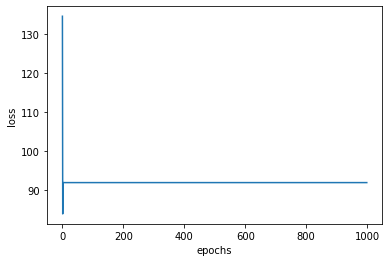

In [0]:
# 手順数による線形分離の学習カーブ
linear_classification.draw_learning_curve(ing_or_stp=1)

義理チョコの時系列グラフ


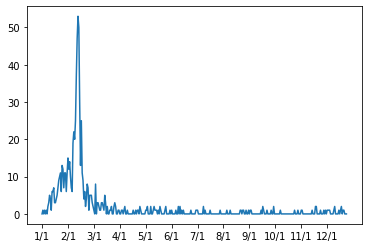

本命チョコの時系列グラフ


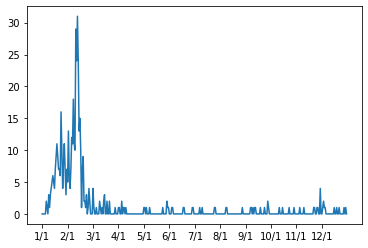

In [13]:
# 時系列データの描画
date_classification.draw_time_series_graph()

義理チョコの時系列グラフ


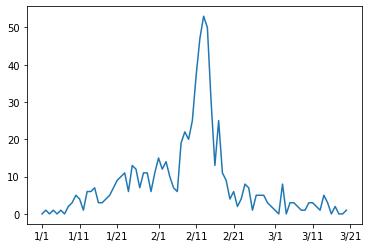

本命チョコの時系列グラフ


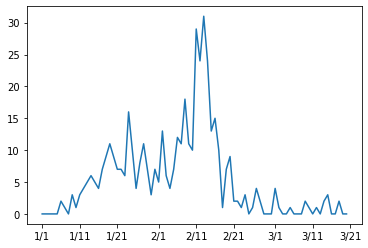

チョコの差分時系列グラフ(本命-義理)


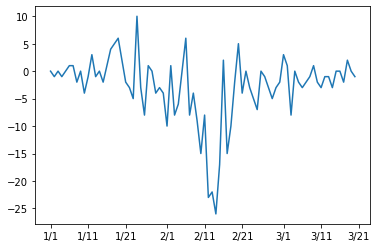

In [8]:
# 時系列データ拡大画像の描画
date_classification.draw_time_series_graph_expanded()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:668: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

未分類　　　　　　　6500  
義理　　　　　　　　788   	割合［％］	60.52227342549923
本命　　　　　　　　514   	割合［％］	39.47772657450077
義理　砂糖　　　　　64    	割合［％］	56.14035087719298
本命　砂糖　　　　　50    	割合［％］	43.85964912280702
義理　グラニュー糖　4     	割合［％］	44.44444444444444
本命　グラニュー糖　5     	割合［％］	55.55555555555556
義理　上白糖　　　　4     	割合［％］	57.142857142857146
本命　上白糖　　　　3     	割合［％］	42.857142857142854
義理　三温糖　　　　2     	割合［％］	40.0  
本命　三温糖　　　　3     	割合［％］	60.0  
文字は潰れていますが、左から、 ['全体', '砂糖', 'グラニュー糖', '上白糖', '三温糖'] です。


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20307 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31958 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12521 missing from current font.
  font.set_

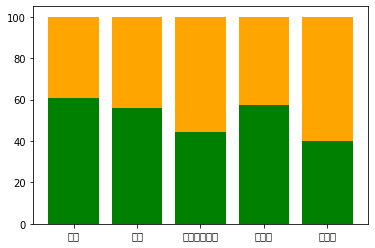

In [15]:
# 料理名を示すチャート
dish_type_classification.draw_bar_chart([["砂糖　　　　　"], ["グラニュー糖　"], ["上白糖　　　　"], ["三温糖　　　　"]])

In [0]:
# 近傍に位置する単語を表示
ingredient_classification.search_neighborhood_word(SEARCH_WORD=["砂糖", "グラニュー糖", "牛乳", "ミルク", "チョコ", "小麦粉", "薄力粉", "水"])

砂糖の近傍
('グラニュー糖', 0.9417458176612854)
('上白糖', 0.883041262626648)
('ブラウンシュガー', 0.8110750913619995)
('板チョコレート無塩バター', 0.8082950711250305)
('分離したチョコ', 0.8044706583023071)
('板チョコレート', 0.7892202138900757)
('粉糖', 0.7825325131416321)
('三温糖', 0.777715265750885)
('粉砂糖', 0.7722015976905823)
('さとう', 0.7652987241744995)

グラニュー糖の近傍
('砂糖', 0.941745936870575)
('上白糖', 0.8922737836837769)
('粉砂糖', 0.851926326751709)
('粉糖', 0.8517646789550781)
('板チョコレート', 0.8126708269119263)
('ブラウンシュガー', 0.8038777709007263)
('チョコレート', 0.7983030080795288)
('製菓用チョコ', 0.7941387295722961)
('板チョコレート無塩バター', 0.7808519601821899)
('〈シュー生地〉', 0.7772840261459351)

牛乳の近傍
('ホワイトソース', 0.8864105939865112)
('オリーブオイル', 0.8738815188407898)
('豆乳又は牛乳', 0.8730136156082153)
('無糖ココア', 0.8719453811645508)
('揚げ油', 0.8553591966629028)
('サラダ油', 0.8480924367904663)
('牛乳or豆乳', 0.84665846824646)
('豆乳', 0.8414188623428345)
('インスタントコーヒー', 0.8383869528770447)
('チョコレートチップ', 0.831373393535614)

ミルクの近傍
('マーマレードジャム', 0.9194799661636353)
('明治', 0.9065250158309

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# 近傍に位置する単語を表示
title_classification.search_neighborhood_word(SEARCH_WORD=["砂糖", "グラニュー糖", "牛乳", "ミルク", "チョコ", "小麦粉", "薄力粉", "水"])

砂糖の近傍
('グラニュー糖', 0.929061770439148)
('上白糖', 0.8605441451072693)
('三温糖', 0.8243306875228882)
('カカオパウダー', 0.8225641846656799)
('グルノーブル', 0.8023755550384521)
('粉砂糖', 0.8017465472221375)
('卵黄に入れる砂糖', 0.7966116666793823)
('粉糖', 0.7954694032669067)
('チョコレートガナッシュ', 0.7890268564224243)
('ココロココアスノーボール', 0.7876818776130676)

グラニュー糖の近傍
('砂糖', 0.9290618300437927)
('上白糖', 0.8760477304458618)
('卵黄に入れる砂糖', 0.8705974817276001)
('グルノーブル', 0.8394722938537598)
('粉砂糖', 0.8168728947639465)
('粉糖', 0.8111625909805298)
('ビタークッキー', 0.8028455972671509)
('三温糖', 0.789588987827301)
('ブラウンシューガー', 0.7819786667823792)
('チョコレートガナッシュ', 0.7816969156265259)

牛乳の近傍
('塩', 0.8870402574539185)
('オリーブオイル', 0.8767737150192261)
('マカデミアンナッツ', 0.8619887828826904)
('打ち粉', 0.859394907951355)
('グランマニエ', 0.8519043922424316)
('仕上げ用', 0.8487454056739807)
('バニラエッセンス', 0.8447645902633667)
('インスタントコーヒー', 0.8427919745445251)
('豆乳', 0.8421467542648315)
('柚子茶', 0.8408825993537903)

ミルクの近傍
('入り', 0.9098894596099854)
('クレープ生地', 0.8855321407318

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# 単語同士の近さを計算
ingredient_classification.calculate_similarity(SIMILAR_WORD=[["砂糖", "グラニュー糖"], ["砂糖", "粉ミルク"], ["水", "牛乳"], ["砂糖", "水"], ["砂糖", "ボウル"]])

砂糖とグラニュー糖の類似度：	0.94174576
砂糖と粉ミルクの類似度：	0.3026641
水と牛乳の類似度：	0.757495
砂糖と水の類似度：	0.13706598
砂糖とボウルの類似度：	0.2350862


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# 単語同士の近さを計算
title_classification.calculate_similarity(SIMILAR_WORD=[["砂糖", "グラニュー糖"], ["水", "牛乳"], ["砂糖", "ボウル"], ["おいしい", "まずい"], ["おいしい", "甘い"], ["手作り", "簡単"]])

砂糖とグラニュー糖の類似度：	0.92906183
水と牛乳の類似度：	0.6956608
砂糖とボウルの類似度：	0.24547118
入力の型が異なる、または該当する単語がない可能性があります
入力の型が異なる、または該当する単語がない可能性があります
手作りと簡単の類似度：	0.74720037


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


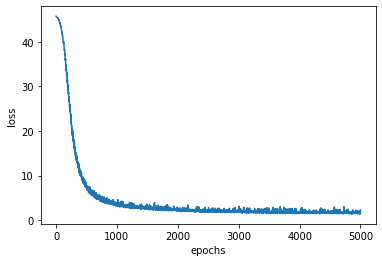

In [0]:
# 材料による分類の学習曲線
ingredient_classification.draw_learning_curve()

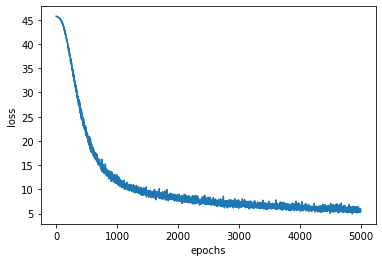

In [0]:
# タイトルによる分類の学習曲線
title_classification.draw_learning_curve()

In [0]:
# 材料による分類器にラベルのないデータを適用
ingredient_classification.inference_by_df(df_extracted.df[df_extracted.df["label"] == -1])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:163: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


                                        id1  ... label
0  0004ed1ccda06dc11ee2609fd180eba0bf7fae7e  ...   1.0
1  000f96559fcc37092a1d87c49e7b45c5964dd279  ...   1.0
2  001e254f56fc4dfe1d6f464a2b34899672649901  ...   0.0
3  0038807acef9e403ee2fdfa97af6043cd7bae39c  ...   0.0
4  0046327939ffe0883b92a7a943e257523df33775  ...   0.0

[5 rows x 9 columns]
DNNより作成した結果csvをresult_label_0.csvに保存しました


In [0]:
# 手順による分類器にラベルのないデータを適用
title_classification.inference_by_df(df_extracted.df[df_extracted.df["label"] == -1])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:184: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:186: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:188: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:190: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, 

                                        id1  ... label
0  0004ed1ccda06dc11ee2609fd180eba0bf7fae7e  ...   0.0
1  000f96559fcc37092a1d87c49e7b45c5964dd279  ...   0.0
2  001e254f56fc4dfe1d6f464a2b34899672649901  ...   0.0
3  0038807acef9e403ee2fdfa97af6043cd7bae39c  ...   0.0
4  0046327939ffe0883b92a7a943e257523df33775  ...   0.0

[5 rows x 9 columns]
DNNより作成した結果csvをresult_label_1.csvに保存しました


In [0]:
# 材料より本命か義理かを予測
ingredient_classification.inference_by_ingredient(ingredients=[["砂糖","生クリーム"],["ゴディバ"],["上白糖"],["抹茶"],["グラニュー糖"]])

        ingredient  label title
index                          
0      [砂糖, 生クリーム]      0      
1           [ゴディバ]      1      
2            [上白糖]      0      
3             [抹茶]      1      
DNNより作成した結果csvをresult_label_2.csvに保存しました


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:163: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [0]:
# 手順より本命か義理かを予測
title_classification.inference_by_title(recipes=["本格生チョコアイス","ハート型手作りショコラ"])

  index        title  label
0     0    本格生チョコアイス      0
1     1  ハート型手作りショコラ      1
DNNより作成した結果csvをresult_label_3.csvに保存しました


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:184: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:186: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:188: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:190: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, 

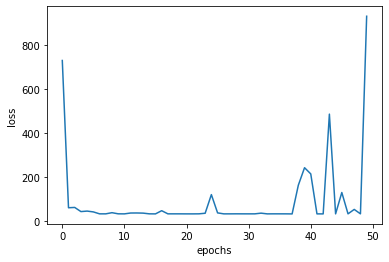

In [0]:
# CNNモデルのloss(ただしval_lossではない)の収束の様子
image_classification_by_cnn.draw_learning_curve()

  id                                             img_np  label
0  0  [[[205, 209, 220], [204, 208, 219], [203, 207,...      1
1  1  [[[55, 108, 149], [56, 108, 149], [61, 110, 15...      1
2  2  [[[131, 182, 225], [129, 179, 222], [130, 179,...      1
3  3  [[[53, 48, 49], [56, 51, 52], [57, 52, 53], [5...      1
4  4  [[[40, 73, 77], [12, 33, 37], [7, 25, 26], [5,...      1
CNNより作成した結果csvをresult_label_1.csvに保存しました
本命
本命
本命
本命
本命
本命
本命


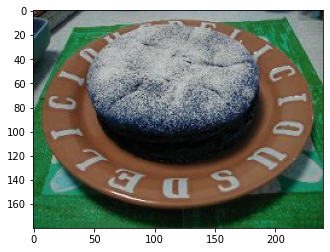

In [0]:
# CNNモデルを用いてサンプル画像の義理/本命を予測
image_classification_by_cnn.inference(paths=[
                                      "/content/drive/My Drive/Colab Notebooks/data/sample_image/giri_sample1.jpg",
                                      "/content/drive/My Drive/Colab Notebooks/data/sample_image/giri_sample2.jpg",
                                      "/content/drive/My Drive/Colab Notebooks/data/sample_image/giri_sample3.jpg",
                                      "/content/drive/My Drive/Colab Notebooks/data/sample_image/honmei_sample1.jpg",
                                      "/content/drive/My Drive/Colab Notebooks/data/sample_image/honmei_sample2.jpg",
                                      "/content/drive/My Drive/Colab Notebooks/data/sample_image/honmei_sample3.jpg",
                                      "/content/drive/My Drive/Colab Notebooks/data/image_folder/1_giri/0091dfd5ab3601d05d0d6bd2a5140943d2466b6b.jpg"
                                      ])

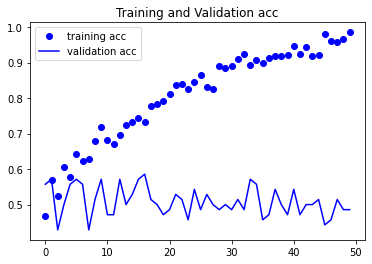

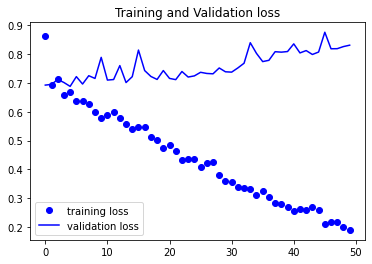

In [0]:
# VGG_1のacc,val_acc,loss,val_lossの様子を表す曲線
image_classification_by_vgg_1.draw_learning_curve()

[0.5136723]


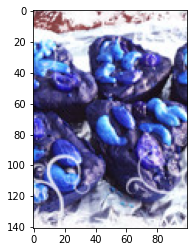

In [0]:
# VGG_2を用いたpathの先の画像の推論(1に近いと本命)
image_classification_by_vgg_2.inference("/content/drive/My Drive/Colab Notebooks/data/image_folder/2_honmei/1023ec34f9ff6ff114e5aca8e1f129088dd601be.jpg")

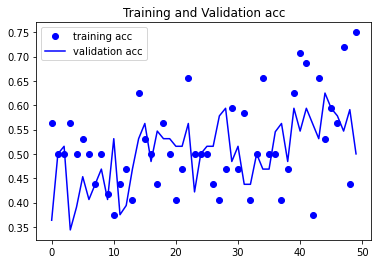

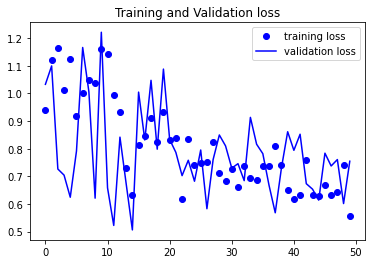

In [0]:
# VGG_2のacc,val_acc,loss,val_lossの様子を表す曲線
image_classification_by_vgg_2.draw_learning_curve()